# Imports

## For plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

## Local imports

In [3]:
from overlap import TrpzOverlap
from utils import grid_from_map, oversample_grid

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
T1 = fits.open("Ref_files/trace_profile_m1.fits")[0].data.squeeze()
T2 = fits.open("Ref_files/trace_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)
T2 = T2.astype(float)

In [5]:
# Normalised spatial profile
P1 = T1 / T1.sum(axis=0)
P1[np.isnan(P1)] = 0.

P2 = T2 / T2.sum(axis=0)
P2[np.isnan(P2)] = 0.

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# Setup for simulation

## Wavelength grid

In [6]:
# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2, wv_range=[0.55, wv_2.max()])
lam_grid_1 = grid_from_map(wv_1, P1, wv_range=[wv_1.min(), 3.0])

# Remove values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

# Oversample by subdividing both grid and finally combine it
lam_simu = np.concatenate([oversample_grid(lam_grid_2, n_os=10), oversample_grid(lam_grid_1, n_os=10)])

# Make sure sorted and unique
lam_simu = np.unique(lam_simu)

## Initiate 2 simulations.
(One without order 2, so no contamination, and with order 2)

In [7]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], lam_grid=lam_simu, thresh=1e-8, c_kwargs={'thresh':0.001})
simu_no_overlap = TrpzOverlap([P1], [wv_1], lam_grid=lam_simu, thresh=1e-8,c_kwargs={'thresh':0.001})

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

# Case 1: Sinus function

## Inject sinus

In [14]:
# Generate flux to inject
flux = 1 + 0.5 * np.sin(lam_simu*500)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= 1e9

# Inject
scidata = simu.rebuild(flux)
clean_data = simu_no_overlap.rebuild(flux)

<IPython.core.display.Javascript object>


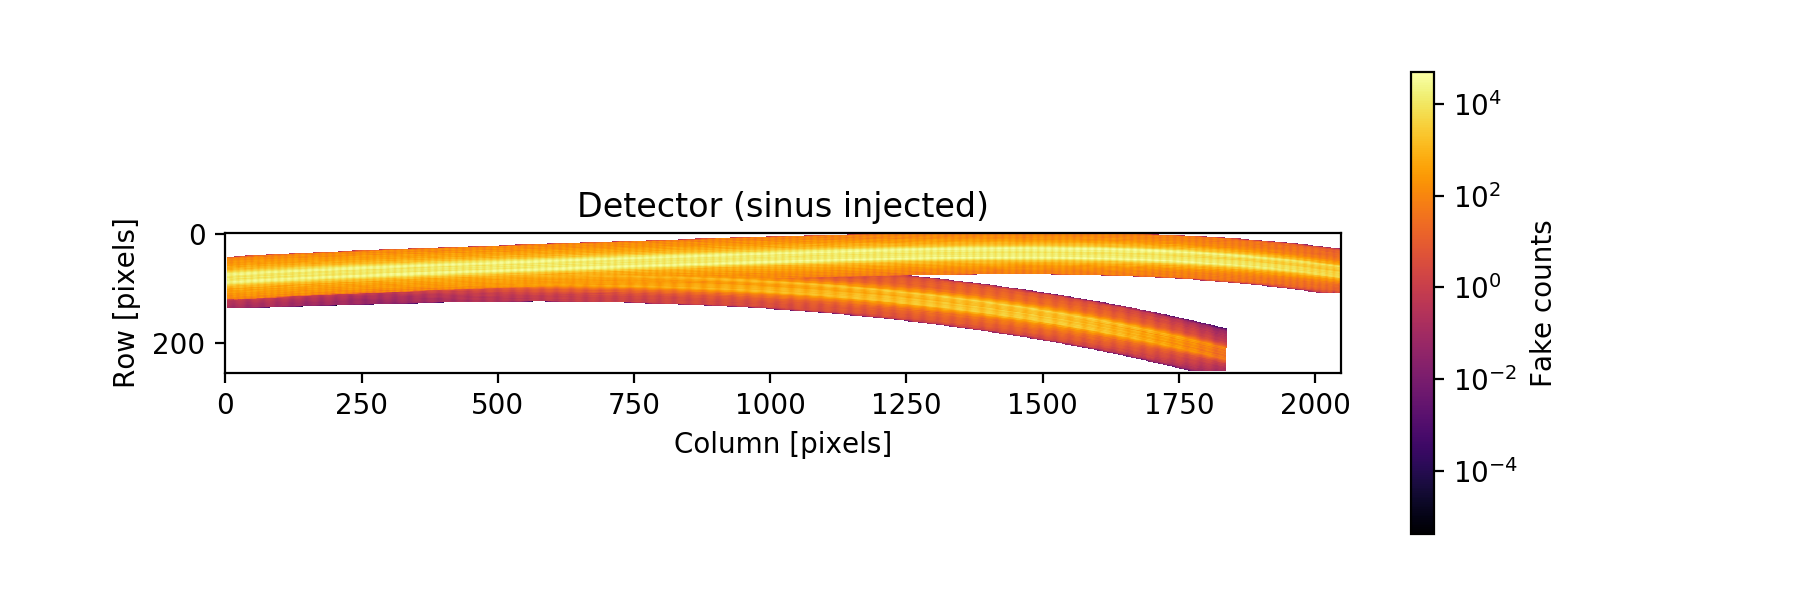

In [9]:
plt.figure(figsize=(9,3))
plt.imshow(scidata, norm=LogNorm())
cmap = plt.colorbar()
plt.title('Detector (sinus injected)')
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
cmap.set_label('Fake counts')

## Init extraction

In [20]:
wv_range = [0.6, 2.836]
n_oversample = 1

# Define grid for extraction
# To be improved, but for now, choose the grid from order 1
lam_grid = grid_from_map(wv_1, P1, wv_range=wv_range)
lam_grid = oversample_grid(lam_grid, n_os=n_oversample)
lam_grid = np.unique(lam_grid)

In [24]:
# Init extraction object
# Use more restrictive cut on the spatial and the kernel
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh':0.0001})

## Extract

In [25]:
f_k = extra.extract()

Note that f_k is not exactly what we are looking for. It is finer that the resolution of the spectrometer,  <br />
so it gives unstable results as shown in the following plot

### Raw f_k

<IPython.core.display.Javascript object>


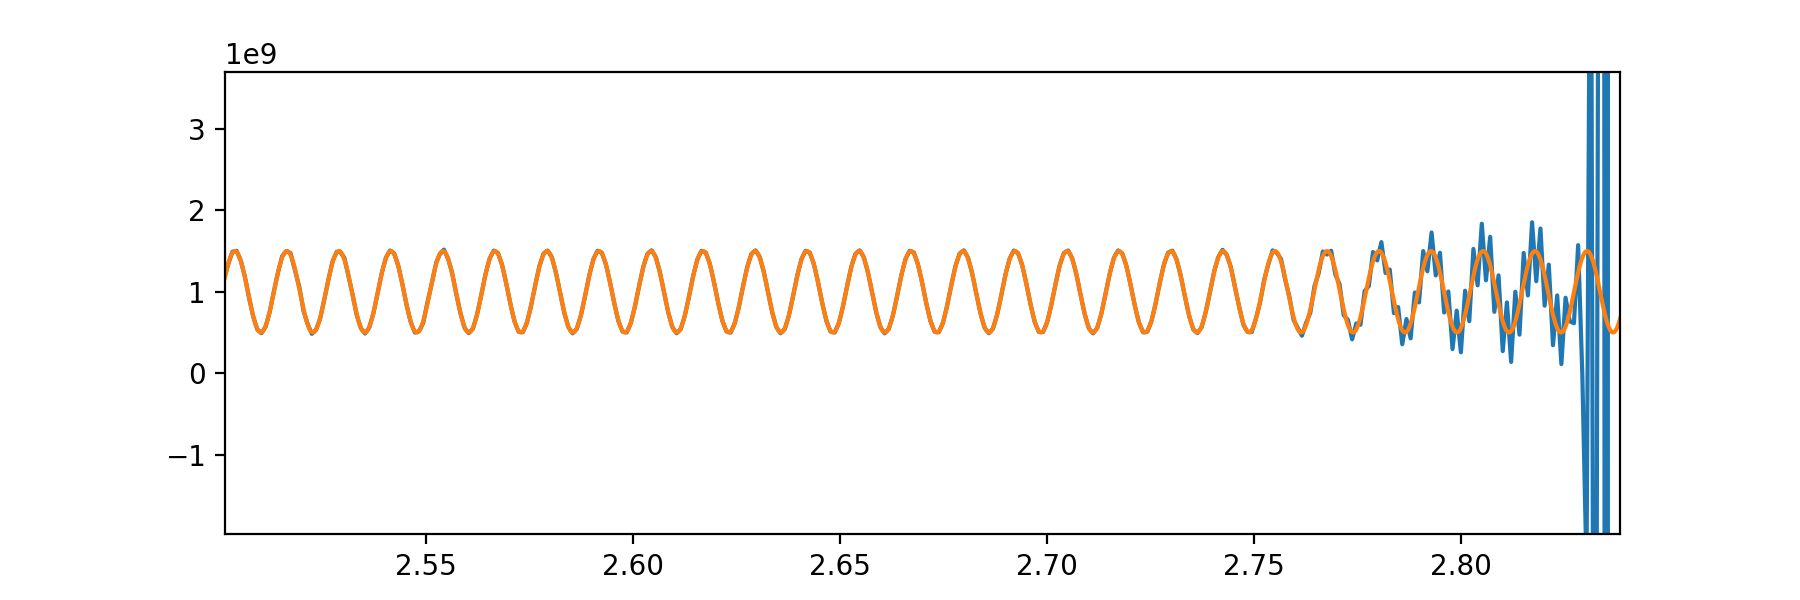

(2.5, 2.84)

In [26]:
plt.plot(extra.lam_grid, f_k)
plt.plot(simu.lam_grid, flux)
plt.xlim(2.5,2.84)

### f_k convolved and binned
To get better results, one option is to convolve f_k and bin.

In [28]:
f_k_c = extra.c_list[0].dot(f_k)
f_k_bin = convolve(f_k_c, Box1DKernel(2*n_oversample),
                   preserve_nan=True, boundary='extend')
# Note that the binned flux for the simulation
# is only valid for the part covered only by order 1
f_th_bin = convolve(simu.c_list[0].dot(flux), Box1DKernel(10*2),
                    preserve_nan=True, boundary='extend')
f_th_bin = interp1d(simu.lam_grid_c(0), f_th_bin, kind='cubic')

<IPython.core.display.Javascript object>


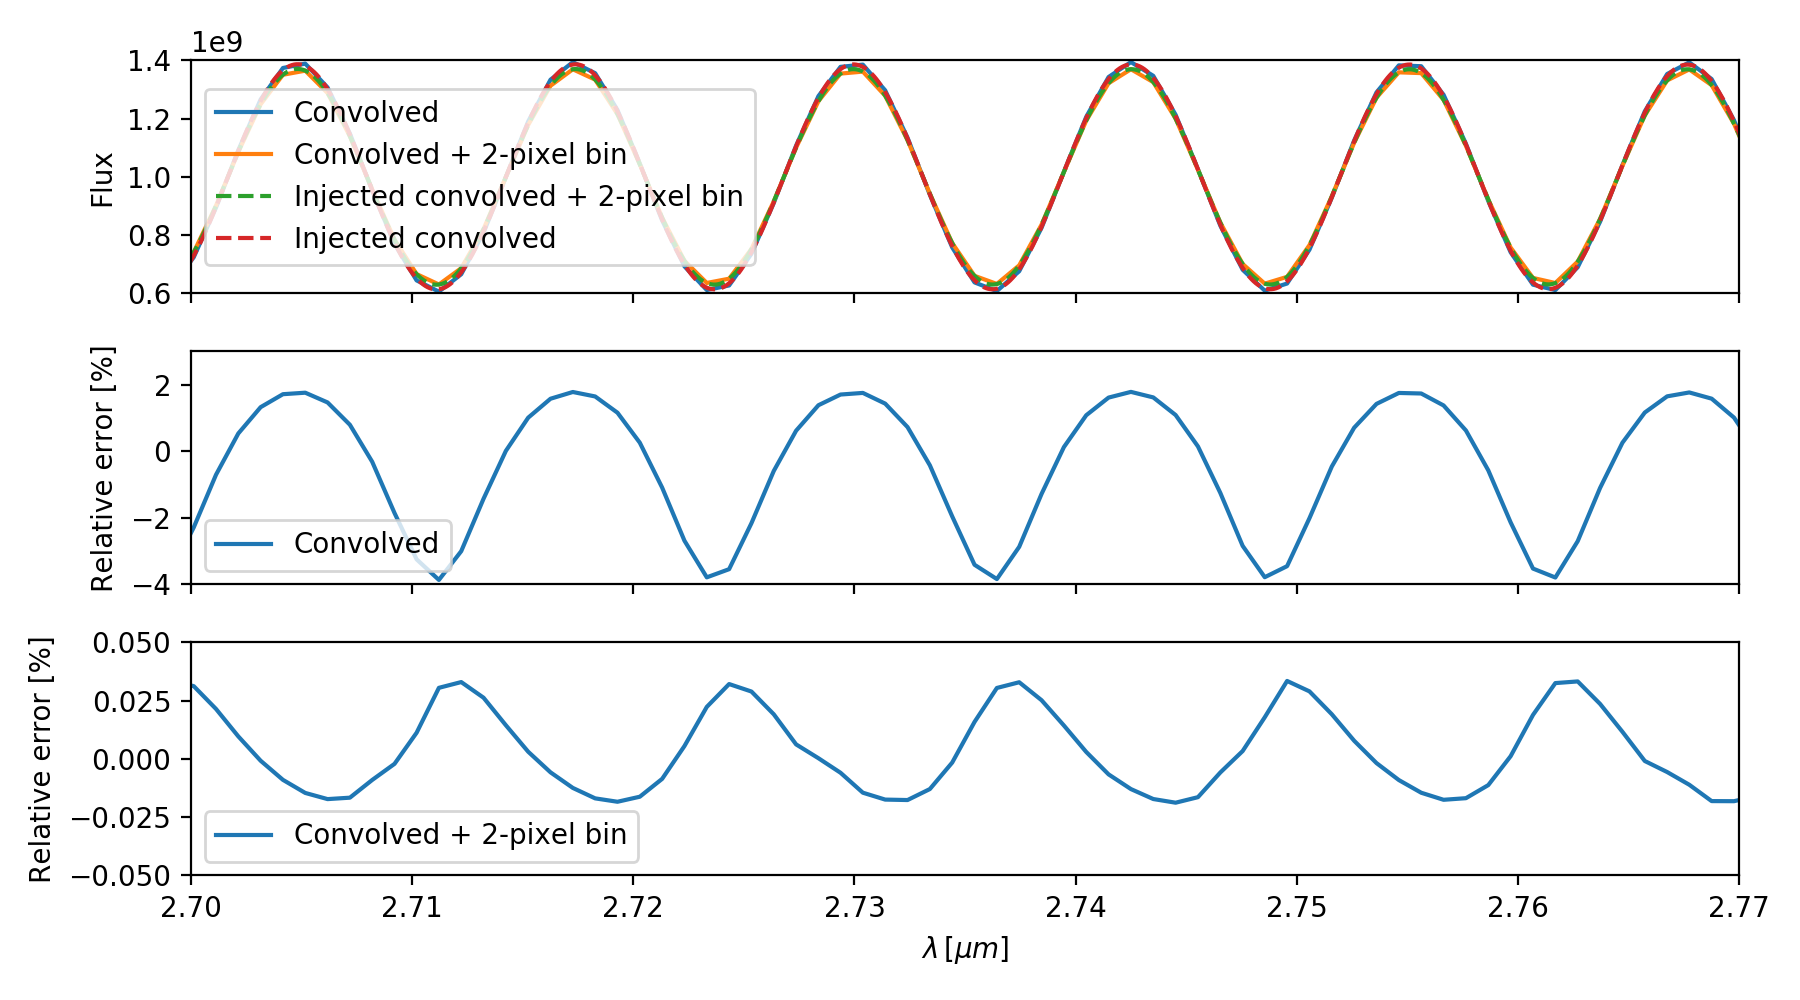

In [43]:
fig, ax = plt.subplots(3,1,sharex=True, figsize=(9,5))

ax[0].plot(extra.lam_grid_c(0), f_k_c, label='Convolved')
ax[0].plot(extra.lam_grid_c(0), f_k_bin, label='Convolved + 2-pixel bin')
ax[0].plot(simu.lam_grid_c(0), f_th_bin(simu.lam_grid_c(0)), '--', label='Injected convolved + 2-pixel bin')
ax[0].plot(simu.lam_grid_c(0), simu.c_list[0].dot(flux), '--', label='Injected convolved')
ax[0].legend()

err_c = (f_k_c - f_th_bin(extra.lam_grid_c(0)))/f_th_bin(extra.lam_grid_c(0))
err_bin = (f_k_bin - f_th_bin(extra.lam_grid_c(0)))/f_th_bin(extra.lam_grid_c(0))
ax[1].plot(extra.lam_grid_c(0), 100*err_c, label='Convolved')
ax[2].plot(extra.lam_grid_c(0), 100*err_bin, label='Convolved + 2-pixel bin')
ax[1].legend()
ax[2].legend()


ax[0].set_ylim(0.6e9, 1.4e9)
ax[1].set_ylim(-4,3)
ax[2].set_ylim(-5e-2,5e-2)

ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Relative error [%]')
ax[2].set_ylabel('Relative error [%]')
plt.xlim(2.7000,2.7700)
plt.xlabel('$\lambda \, [\mu m]$')
plt.tight_layout()

### Rebuilt (projection on the detector)
But the best is to recreate the 2-D image of the detector (after all, the algorithm is made to optimize that)

In [44]:
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


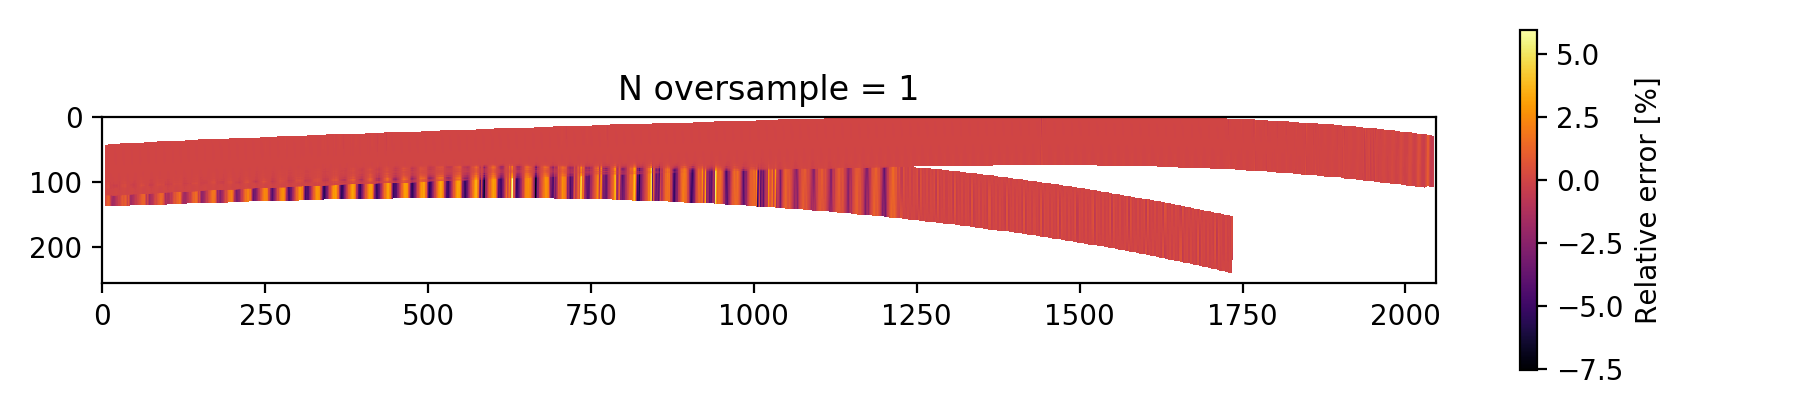

<IPython.core.display.Javascript object>


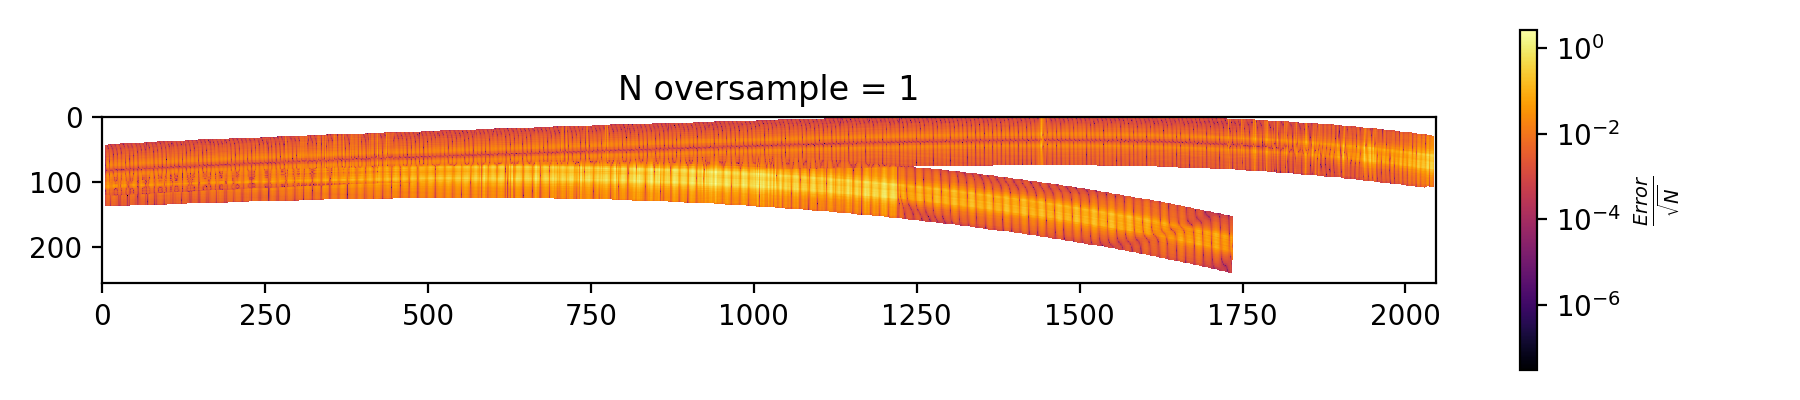

In [69]:
plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100)
plt.colorbar(label="Relative error [%]")
plt.tight_layout()
plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm())
plt.colorbar(label=r"$\frac{Error}{\sqrt{N}}$")
plt.tight_layout()

The major source of error is due to the coarse sampling compared to order 2 resolution and the convolution kernels. <br/> 
This causes the error seen in the order 2 where the wavelength start to be shared with order 1

### Non-uniform grid
Use a finer grid for the wavelengths covered by order 2

In [90]:
n_oversample = 3

# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2)
lam_grid_1 = grid_from_map(wv_1, P1)

# Remove values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

# Oversample by subdividing both grid and finally combine it
lam_grid = np.concatenate([oversample_grid(lam_grid_2, n_os=n_oversample),
                           oversample_grid(lam_grid_1, n_os=n_oversample)])

# Make sure sorted and unique
lam_grid = np.unique(lam_grid)

In [91]:
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh':0.0001})

In [92]:
f_k = extra.extract()
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


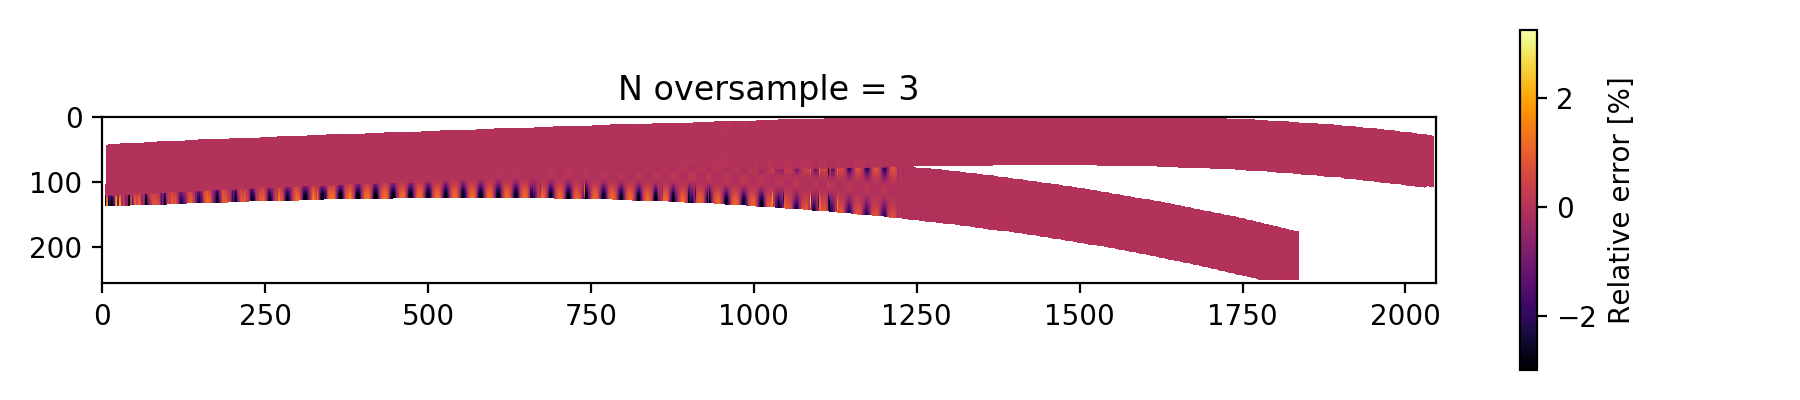

<IPython.core.display.Javascript object>


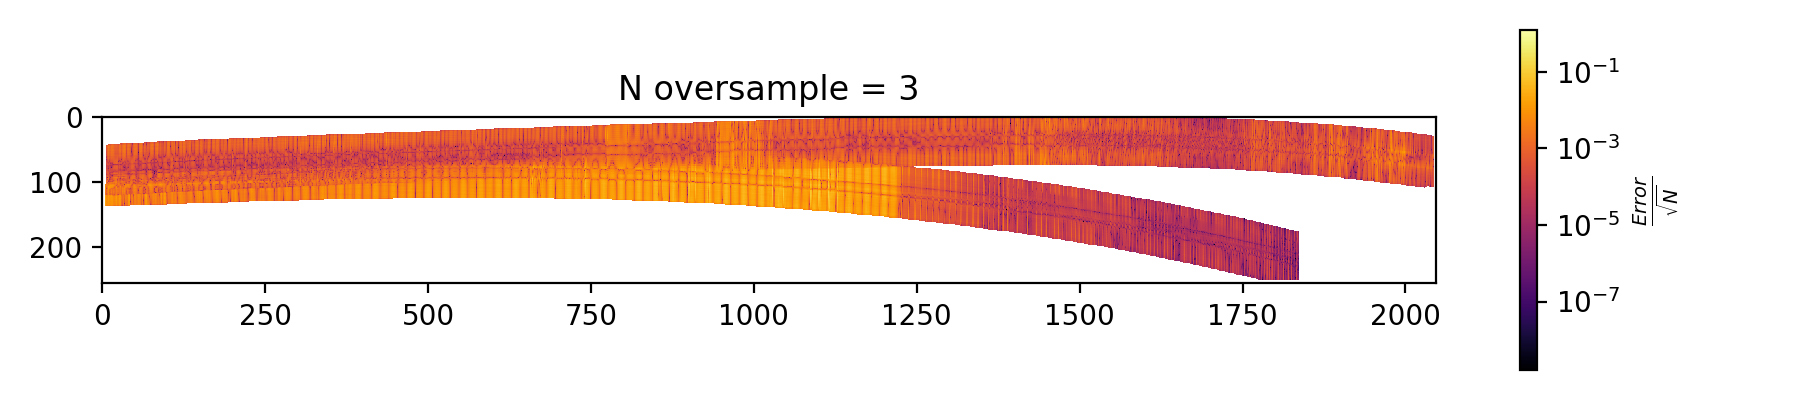

In [93]:
plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100, vmin=-3)
plt.colorbar(label="Relative error [%]")
plt.tight_layout()
plt.figure(figsize=(9,2))
plt.title("N oversample = {}".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm())
plt.colorbar(label=r"$\frac{Error}{\sqrt{N}}$")
plt.tight_layout()

# Case 2: Sinus function + noise

## Add noise

In [35]:
data_noise = scidata.copy()
clean_data_noise = clean_data.copy()

In [36]:
# Add Poisson noise
data_noise[np.isnan(data_noise)] = 0
data_noise = np.random.poisson(data_noise)
clean_data_noise[np.isnan(clean_data_noise)] = 0
clean_data_noise = np.random.poisson(clean_data_noise)

# Add background noise
data_noise = data_noise + np.random.normal(scale=20, size=data_noise.shape)
clean_data_noise = clean_data_noise + np.random.normal(scale=20, size=clean_data_noise.shape)

# Get the noise
noise = data_noise-scidata
noise_clean = clean_data_noise-clean_data

## Init extraction

In [59]:
sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
wv_range = [0.6, 2.836]
n_oversample = 1

# Define grid for extraction
# To be improved, but for now, choose the grid from order 1
lam_grid = grid_from_map(wv_1, P1, wv_range=wv_range)
lam_grid = oversample_grid(lam_grid, n_os=n_oversample)
lam_grid = np.unique(lam_grid)

In [23]:
# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2, wv_range=[0.7, wv_2.max()])
lam_grid_1 = grid_from_map(wv_1, P1, wv_range=[wv_1.min(), 2.8])

# Revome values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

# Oversample by subdividing both grid and finally combine it
lam_grid = np.concatenate([oversample_grid(lam_grid_2, n_os=n_oversample),
                           oversample_grid(lam_grid_1, n_os=n_oversample)])

# Make sure sorted and unique
lam_grid = np.unique(lam_grid)

In [60]:
# Init extraction object
# Use more restrictive cut on the spatial and the kernel
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=data_noise, lam_grid=lam_grid, thresh=1e-5,
                     c_kwargs={'thresh':0.001}, sig=sig)

In [61]:
f_k = extra.extract()

In [62]:
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


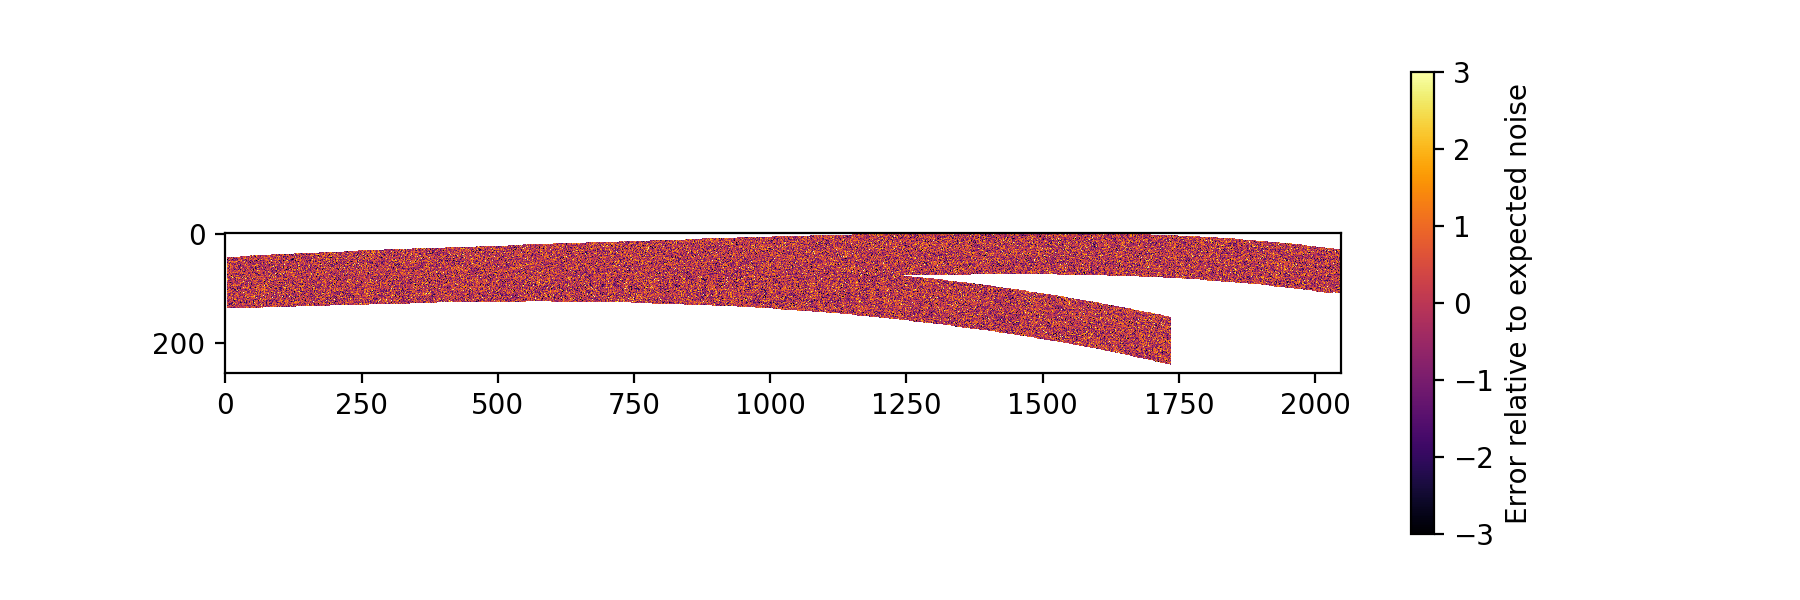

In [63]:
plt.imshow((rebuilt-data_noise)/sig, vmin=-3, vmax=3)
plt.colorbar(label="Error relative to expected noise")